# 🚁 CV Drone Pipeline: Обучение модели детекции

Этот ноутбук управляет полным циклом подготовки данных и обучения модели YOLO. Все параметры настраиваются в файле config/config.yaml.

## Этапы пайплайна:

1. Preprocess: Извлечение кадров из видео и удаление дубликатов.

2. Auto-Labeling: Автоматическая разметка данных и разделение на Train/Val/Test.

3. Training: Запуск обучения или дообучения.

4. Validation: Тестирование модели на фото и видео.

5. Export: Конвертация обученной модели в формат ONNX. (по желанию)

In [1]:
import os
import sys

# Добавляем корневую директорию в путь, чтобы импорты из папки scripts работали корректно
sys.path.append(os.path.abspath('.'))

# Импортируем функции из ваших модулей
from scripts.video_parser import extract_frames
from scripts.deduplicator import remove_duplicates
from scripts.auto_labeller import run_auto_annotation, visualize_annotations, create_training_dataset
from scripts.trainer import train_yolo_model
from scripts.photo_tester import run_prediction as test_photos
from scripts.video_tester import process_video_with_tracking, init_model, load_config
from scripts.converter import pt2onnx


print("✅ Все модули успешно загружены")

✅ Все модули успешно загружены


## Этап 1: Подготовка изображений (Preprocessing)

На этом этапе мы превращаем сырые видео в набор уникальных кадров.

In [5]:
# 1. Извлекаем кадры из видео согласно FPS в конфиге
print("--- Шаг 1: Парсинг видео ---")
extract_frames()

# 2. Удаляем визуально похожие кадры (дедупликация)
print("\n--- Шаг 2: Дедупликация ---")
remove_duplicates()

--- Шаг 1: Парсинг видео ---
--- [START] Извлечение кадров: FPS=0.33, Качество (q:v)=2
Обработка: 02-07-2025.mp4...
Обработка: 05-07-2025.mp4...
Обработка: 12-07-2025.mp4...
Обработка: 13-09-2025.mp4...
Обработка: 16-09-2025.mp4...
Обработка: 28-07-2025.mp4...

--- [FINISH] Обработка завершена!
Всего кадров в папке: 180

--- Шаг 2: Дедупликация ---
--- [START] Дедупликация в папке: data/raw_data/raw_frames
--- Метод: phash, Порог: 5
Дубликат: 12-07-2025_f0007.jpg похож на 12-07-2025_f0006.jpg
Дубликат: 12-07-2025_f0008.jpg похож на 12-07-2025_f0006.jpg
Дубликат: 16-09-2025_f0018.jpg похож на 16-09-2025_f0017.jpg
Дубликат: 28-07-2025_f0023.jpg похож на 28-07-2025_f0022.jpg
Дубликат: 28-07-2025_f0024.jpg похож на 28-07-2025_f0022.jpg
Дубликат: 28-07-2025_f0031.jpg похож на 28-07-2025_f0030.jpg

Итоги дедупликации:
   Было: 180
   Удалено: 6
   Осталось: 174


6

## Этап 2: Авторазметка и подготовка датасета

На этом этапе мы генерируем аннотации с помощью предобученной модели. 

Результат сохраняется в двух форматах: плоская структура с архивом archive.zip (для импорта в CVAT) и разделенный на выборки датасет (для обучения YOLO).

### 1. Генерация аннотаций и архива для CVAT

Скрипт создаст папку obj_train_data и упакует её вместе со служебными файлами (obj.data, obj.names) в архив.

In [2]:
print("--- Шаг 2.1: Авторазметка и создание archive.zip ---")
run_auto_annotation()

--- Шаг 2.1: Авторазметка и создание archive.zip ---
--- [START] Авторазметка для CVAT: 174 изображений ---
--- [INFO] Авторазметка завершена. Архив создан: data/auto_annotations\archive.zip


### 2. Визуальный контроль качества

Перед тем как обучать модель, проверим, как отработала авторазметка на сырых данных.

--- Шаг 2.2: Визуальная проверка ---


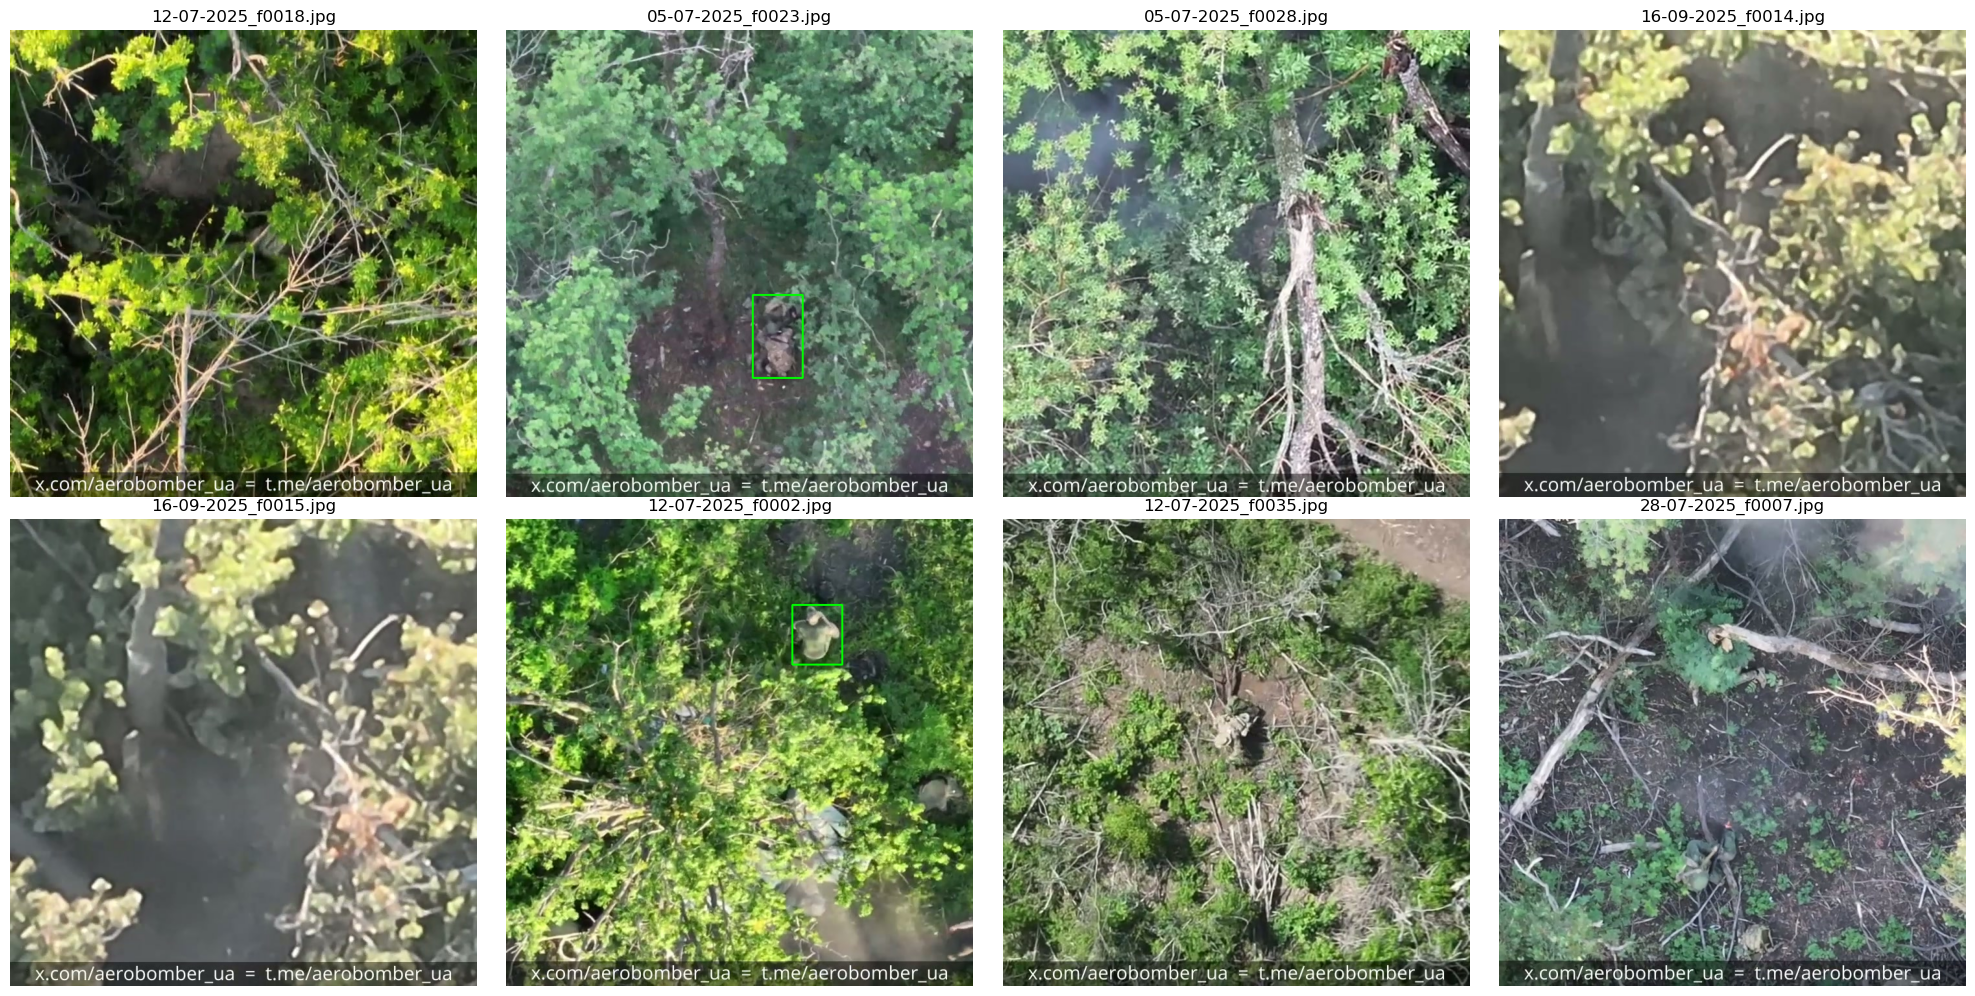

In [6]:
# keep_empty_images=False отфильтрует только те фото, где модель нашла солдат
print("--- Шаг 2.2: Визуальная проверка ---")
visualize_annotations(num_images=8, keep_empty_images=True)

### 3. Формирование финального датасета (Train/Val/Test)

Теперь распределяем размеченные данные по папкам, согласно пропорциям из config.yaml.

In [ ]:
# Шаг 3: Сплит данных и создание data.yaml для обучения
# keep_empty_images=True добавит пустые кадры в обучение для уменьшения False Positive
print("--- Шаг 2.3: Финальный Split и подготовка к обучению ---")
create_training_dataset(keep_empty_images=True)

## Этап 3: Обучение модели

Запуск процесса обучения. Параметры (эпохи, batch size, устройство) берутся из config.yaml.

In [4]:
print("--- Шаг 4: Запуск обучения YOLO ---")
# Функция вернет результаты обучения
train_results = train_yolo_model()

--- Шаг 4: Запуск обучения YOLO ---
--- [MODE] Режим СТАНДАРТНОГО обучения. Загружаем: models\best_5783f.pt
New https://pypi.org/project/ultralytics/8.3.241 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.145  Python-3.12.3 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data/train_data\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=mod

train: Scanning C:\Users\sanek\OneDrive\Рабочий стол\full_cv_drone\cv_pipeline\data\train_data\labels\train... 27 images, 112 backgrounds, 0 corrupt: 100%|██████████| 139/139 [00:00<00:00, 1063.12it/s]

train: New cache created: C:\Users\sanek\OneDrive\ \full_cv_drone\cv_pipeline\data\train_data\labels\train.cache


val: Fast image access  (ping: 0.00.0 ms, read: 11.32.5 MB/s, size: 152.5 KB)


val: Scanning C:\Users\sanek\OneDrive\Рабочий стол\full_cv_drone\cv_pipeline\data\train_data\labels\val... 6 images, 11 backgrounds, 0 corrupt: 100%|██████████| 17/17 [00:00<00:00, 452.99it/s]

val: New cache created: C:\Users\sanek\OneDrive\ \full_cv_drone\cv_pipeline\data\train_data\labels\val.cache


Plotting labels to outputs\train_5783f2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)


2025/12/26 13:10:47 INFO mlflow.tracking.fluent: Experiment with name 'outputs' does not exist. Creating a new experiment.
2025/12/26 13:10:48 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(f2f880076b4c4856b3f760e52a0f512b) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to outputs\train_5783f2
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       2.4G      1.422      10.89      1.342          2        640: 100%|██████████| 9/9 [00:03<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.69it/s]

                   all         17          7      0.814      0.631      0.857      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.68G      1.701      4.535      1.518          1        640: 100%|██████████| 9/9 [00:02<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.93it/s]

                   all         17          7          1      0.777      0.877       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5       2.7G      1.578      2.676      1.413          6        640: 100%|██████████| 9/9 [00:02<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]

                   all         17          7      0.682      0.714      0.818      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.71G      1.487       2.33      1.371          9        640: 100%|██████████| 9/9 [00:02<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.32it/s]

                   all         17          7      0.965      0.429      0.691      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.73G      1.633       3.37      1.436          3        640: 100%|██████████| 9/9 [00:02<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.39it/s]

                   all         17          7      0.968      0.429      0.649      0.521



5 epochs completed in 0.005 hours.
Optimizer stripped from outputs\train_5783f2\weights\last.pt, 5.5MB
Optimizer stripped from outputs\train_5783f2\weights\best.pt, 5.5MB

Validating outputs\train_5783f2\weights\best.pt...
Ultralytics 8.3.145  Python-3.12.3 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.13it/s]


                   all         17          7          1      0.776      0.877       0.75
Speed: 0.2ms preprocess, 3.5ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to outputs\train_5783f2
MLflow: results logged to runs\mlflow
MLflow: disable with 'yolo settings mlflow=False'
--- [FINISH] Обучение завершено. Результаты в: outputs/train_5783f


## Этап 4: Тестирование и Инференс

Проверяем, как обученная модель справляется с новыми данными (папки test_data и test_videos).

In [ ]:
print("--- Шаг 5: Тестирование на фото ---")
test_photos()

print("\n--- Шаг 6: Тестирование на видео (Tracking) ---")
# Загружаем конфиг для получения путей
cfg = load_config()

# Инициализируем только что обученную модель
# (Укажите путь к вашей модели, если он отличается от стандартного в конфиге)
model_path = os.path.join(cfg["paths"]["models_dir"], cfg["predict"]["model"])
trained_model = init_model(model_path, device=cfg["predict"]["device"])

process_video_with_tracking(
    model=trained_model,
    input_video_path=cfg["paths"]["test_video_dir"],
    output_video_path=cfg["paths"]["test_video_results"],
    show_video=False,
    save_video=True,
    conf=cfg["predict"]["conf"]
)

## Этап 5: Экспорт для продакшена

Конвертируем .pt веса в формат .onnx для высокой производительности.

In [ ]:
print("--- Шаг 7: Экспорт модели в ONNX ---")
# Функция pt2onnx сама найдет путь из конфига, если не передать аргумент
onnx_file = pt2onnx()

if onnx_file:
    print(f"🚀 Пайплайн завершен! Модель готова к работе: {onnx_file}")